In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

from tqdm import tqdm

import os
import random
import functools

import sys
sys.path.append('../')

from dataloader.dataloader import *
from training.training import *
from models.rae import *
from utils.utils import *
from visualizations.visualizations import *
from evaluation.evaluation import *

In [2]:
data_folder = "../Data/Data v5"
df = pd.read_csv(os.path.join(data_folder, "amari_ue_data_final_v5_smoothed_scaled.csv"))
df = df.sort_values(["imeisv", "_time"], ascending = True)
df['imeisv'] = df['imeisv'].astype(str)

/tmp/ipykernel_190486/1554114771.py:2: DtypeWarning: Columns (16,24,26,27,32,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(data_folder, "amari_ue_data_final_v5_smoothed_scaled.csv"))


In [3]:
benign_data_starting_point = "2024-03-20 14:14:50.19"
benign_data_ending_point = "2024-03-23 16:26:19.00"


benign_filter_1 = (df['_time'].between(benign_data_starting_point, benign_data_ending_point))
benign_filter_2 = (~df['imeisv'].isin(['8642840401594200', '8642840401612300','8642840401624200','3557821101183501']))
benign_filter_3 = (df['label'] == 0)
benign_data_filter = (benign_filter_1 & benign_filter_2 & benign_filter_3)

In [4]:
# benign data
benign_data_train = df[benign_data_filter].copy()
benign_data_train = benign_data_train.sort_values(['imeisv','_time'])
print(benign_data_train.shape[0])

260051


In [5]:
benign_data_test_period_start = "2024-03-24 01:20:00.19"
benign_devices_for_testing = ['8609960468879057', '8628490433231157','8677660403123800']

benign_filter_4 = (df['_time'] >= benign_data_test_period_start)
benign_filter_5 = (df['imeisv'].isin(benign_devices_for_testing))
benign_data_filter_test = (benign_filter_3 & benign_filter_4 & benign_filter_5)

benign_data_test = df[benign_data_filter_test].copy()
benign_data_test = benign_data_test.sort_values(['imeisv','_time'])
print(benign_data_test.shape[0])

90102


In [6]:
#malicious data
attck_1_start = "2024-03-23 21:26:00"
attck_1_end = "2024-03-23 22:23:00"
ues_to_exclude_in_1st_attck = [
    '8628490433231157','8609960480666910',
    '3557821101183501'] #'8677660403123800' '8642840401594200'

attck_2_start = "2024-03-23 22:56:00"
attck_2_end = "2024-03-23 23:56:00"
ues_to_exclude_in_2nd_attck = [
    '8609960480666910','8642840401612300'
]

mal_filter_1 = (
    df['_time'].between(attck_1_start, attck_1_end)
    & (~df['imeisv'].isin(ues_to_exclude_in_1st_attck))
)

mal_filter_2 = (
    df['_time'].between(attck_2_start, attck_2_end)
    & (~df['imeisv'].isin(ues_to_exclude_in_2nd_attck))
)

mal_filter_3 = (df['label'] == 1)

malicious_data = df[(mal_filter_1 | mal_filter_2) & mal_filter_3].copy()
malicious_data = malicious_data.sort_values(['imeisv','_time'])
print(malicious_data.shape[0])

10971


In [11]:
feature_columns = [
    'dl_bitrate','ul_bitrate', 
    'cell_x_dl_retx', 'cell_x_dl_tx',
    'cell_x_ul_retx', 'cell_x_ul_tx',
    'ul_total_bytes_non_incr', 'dl_total_bytes_non_incr'
    ]

# feature_columns = ['ul_bitrate']

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Training on GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Training on CPU.")

CUDA is available. Training on GPU.


### Intra vs Inter class variability

In [ ]:
def calculate_euclidean_distances(batch1, batch2, num_of_features):
    batch1_reshaped = batch1.view(-1, num_of_features)
    batch2_reshaped = batch2.view(-1, num_of_features)
    
    if batch1_reshaped.shape != batch2_reshaped.shape:
        return np.NaN
    
    distances = torch.zeros(num_of_features)
    
    for i in range(num_of_features):
        distances[i] = torch.norm(batch1_reshaped[:, i] - batch2_reshaped[:, i], p=2)
        
    return distances

In [ ]:
test_batch_size = 5
benign_data_loader, mal_data_loader = create_test_ds_loaders(
    benign_data_test, 
    malicious_data, 
    120, 
    30, 
    features = feature_columns, 
    batch_size = test_batch_size
)

In [ ]:
benign_data = [*map(lambda x: x[0], benign_data_loader)]
mal_data = [*map(lambda x: x[0], mal_data_loader)]
benign_data_sampled = random.sample(benign_data, len(mal_data))

In [ ]:
num_of_features = len(feature_columns)

In [ ]:
%%time

A = torch.zeros((len(benign_data), len(benign_data_sampled), num_of_features))

for i, benign_i in enumerate(benign_data):
    for j, benign_j in enumerate(benign_data_sampled):
        if i != j:
            A[i, j] = calculate_euclidean_distances(benign_i, benign_j, num_of_features)

In [ ]:
%%time

B = torch.zeros((len(benign_data), len(mal_data), num_of_features))

for i, benign_tensor in enumerate(benign_data):
    for j, mal_tensor in enumerate(mal_data):
        B[i, j] = calculate_euclidean_distances(benign_tensor, mal_tensor, num_of_features)

In [ ]:
A.shape, B.shape

In [ ]:
matrices_A = [A[:,:,i].numpy().copy() for i in range(num_of_features)]
matrices_B = [B[:,:,i].numpy().copy() for i in range(num_of_features)]

In [ ]:
forb_norm_matrices_A = [*map(lambda X: np.linalg.norm(X[:-1,:-1], 'fro'), matrices_A)] 
forb_norm_matrices_B = [*map(lambda X: np.linalg.norm(X[:-1,:-1], 'fro'), matrices_B)] 

In [ ]:
for num, (a,b) in enumerate(zip(forb_norm_matrices_A, forb_norm_matrices_B)):
    print(f"feature {feature_columns[num]}, within class variability:{format(a, '.2f')}, intra class variability:{format(b, '.2f')}")

### Numerical Analysis of NN outputs

In [9]:
import torch.nn as nn
import torch

In [12]:
benign_test_data_loader, mal_test_data_loader = create_test_ds_loaders(
    benign_data_test, 
    malicious_data, 
    120, 
    40, 
    feature_columns, 
    32
)

In [13]:
if len(feature_columns) > 1:
    axis_to_calc_norm = (1,2)
else:
    axis_to_calc_norm = 1

benign_ts_data = torch.cat([batch[0] for batch in [*benign_test_data_loader]])
mal_ts_data = torch.cat([batch[0] for batch in [*mal_test_data_loader]], dim=0)

benign_ts_data_norm1 = np.squeeze(np.linalg.norm(benign_ts_data, ord=1, axis = axis_to_calc_norm))
benign_ts_data_norm2 = np.squeeze(np.linalg.norm(benign_ts_data, axis = axis_to_calc_norm))

mal_ts_data_norm1 = np.squeeze(np.linalg.norm(mal_ts_data, ord=1, axis = axis_to_calc_norm))
mal_ts_data_norm1_sampled = np.random.choice(mal_ts_data_norm1, size=benign_ts_data_norm1.shape[0])

mal_ts_data_norm2 = np.squeeze(np.linalg.norm(mal_ts_data, axis = axis_to_calc_norm))
mal_ts_data_norm2_sampled = np.random.choice(mal_ts_data_norm2, size=benign_ts_data_norm2.shape[0])

In [14]:
def plot_dist_plt(benign_ts, mal_ts, title, nbins_ben = 50, nbins_mal = 50, x_axis_range = [None, None]):

    plt.figure(figsize=(10, 6))
    plt.hist(benign_ts, bins=nbins_ben, color='blue', alpha=0.5, label='Benign')
    plt.hist(mal_ts, bins=nbins_mal, color='red', alpha=0.5, label='Malicious')
    plt.legend()

    plt.title(title)
    plt.xlabel('Values')
    plt.ylabel('Count')

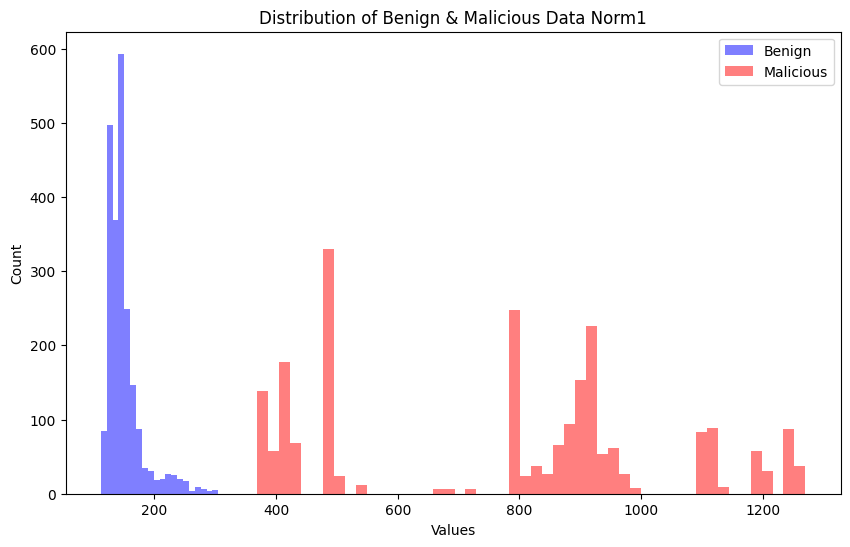

In [15]:
plot_dist_plt(
    benign_ts_data_norm1, 
    mal_ts_data_norm1_sampled,
    'Distribution of Benign & Malicious Data Norm1', 
    nbins_ben = 20, 
    nbins_mal = 50, 
    x_axis_range = [None, None]
)

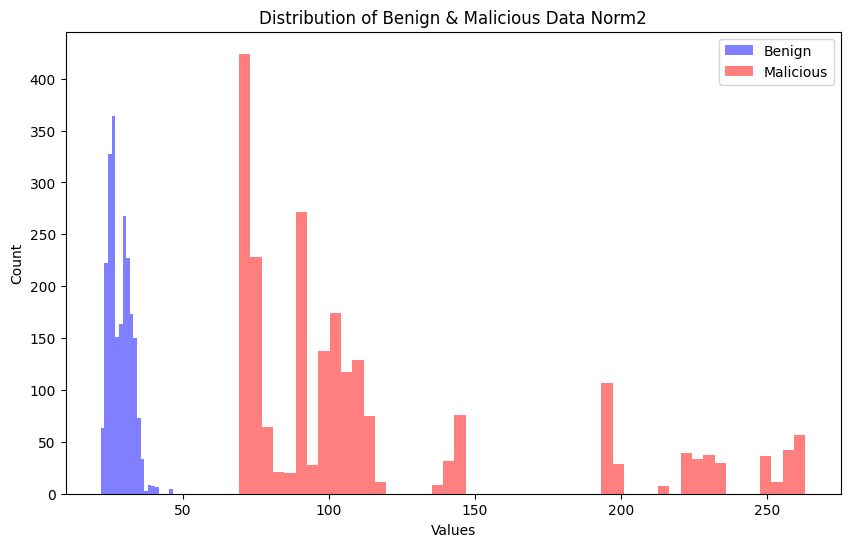

In [16]:
plot_dist_plt(
    benign_ts_data_norm2, 
    mal_ts_data_norm2_sampled,
    'Distribution of Benign & Malicious Data Norm2', 
    nbins_ben = 20, 
    nbins_mal = 50, 
    x_axis_range = [None, None]
)

In [17]:
random_model = LSTMAutoencoder(
    input_dim = len(feature_columns), 
    hidden_dim1 = 50, 
    hidden_dim2 = 100, 
    output_dim = len(feature_columns),
    dropout = 0.2,
    layer_norm_flag = False
)

In [18]:
random_model.to(device)
random_model.eval()

with torch.no_grad(): 
    benign_random_model_outputs = []
    for instance in benign_ts_data:
        instance = instance.to(device)
        benign_random_model_outputs.append(random_model(instance).to('cpu').numpy())

with torch.no_grad():  
    mal_random_model_outputs = []
    for instance in mal_ts_data:
        instance = instance.to(device)
        mal_random_model_outputs.append(random_model(instance).to('cpu').numpy())

In [19]:
if len(feature_columns) > 1:
    axis_to_calc_norm = (1,2)
else:
    axis_to_calc_norm = 1

benign_ts_random_model_out_norm1 = np.squeeze(np.linalg.norm(np.array(benign_random_model_outputs), ord=1, axis = axis_to_calc_norm))
mal_ts_random_model_out_norm1 = np.squeeze(np.linalg.norm(np.array(mal_random_model_outputs), ord=1, axis = axis_to_calc_norm))
mal_ts_random_model_out_norm1_sampled = np.random.choice(mal_ts_random_model_out_norm1, size=benign_ts_random_model_out_norm1.shape[0])

benign_ts_random_model_out_norm2 = np.squeeze(np.linalg.norm(np.array(benign_random_model_outputs), axis = axis_to_calc_norm))
mal_ts_random_model_out_norm2 = np.squeeze(np.linalg.norm(np.array(mal_random_model_outputs), axis = axis_to_calc_norm))
mal_ts_random_model_out_norm2_sampled = np.random.choice(mal_ts_random_model_out_norm2, size=benign_ts_random_model_out_norm2.shape[0])

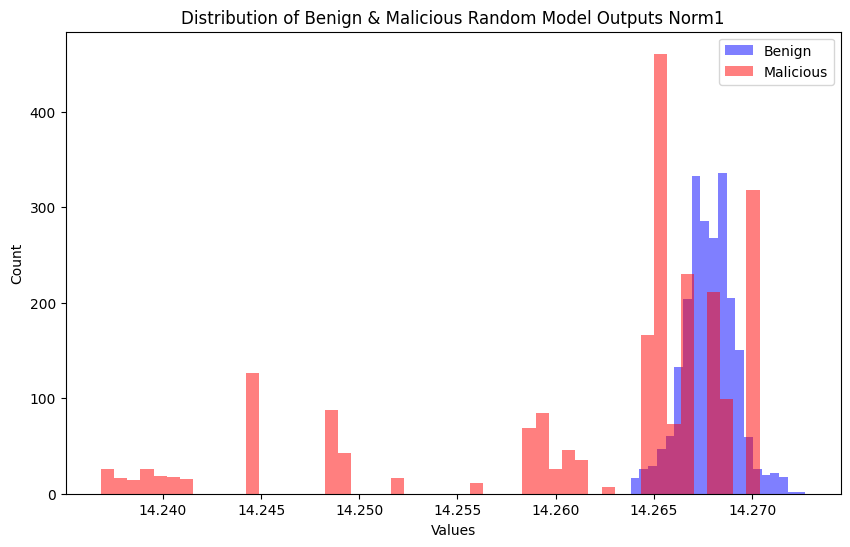

In [20]:
plot_dist_plt(
    benign_ts_random_model_out_norm1, 
    mal_ts_random_model_out_norm1_sampled,
    'Distribution of Benign & Malicious Random Model Outputs Norm1', 
    nbins_ben = 20, 
    nbins_mal = 50, 
    x_axis_range = [None, None]
)

In [37]:
exp_parameters = {'window_size': 120,
  'step_size': 40,
  'batch_size': 32,
  'hidden_dim1': 50,
  'hidden_dim2': 100,
  'dropout': 0.2,
  'layer_norm_flag': False,
  'loss_function': 'L1Loss',
  'lr': 0.001,
  'num_epochs': 52}

#exp_hist = load_history_with_pickle('../results/5bfa52f8-e8c6-4899-963d-3ebd80be60f9_history.pkl')
exp_hist = load_history_with_pickle("./standalone_history.pkl")


model = LSTMAutoencoder(
    input_dim = len(feature_columns), 
    hidden_dim1 = exp_parameters['hidden_dim1'], 
    hidden_dim2 = exp_parameters['hidden_dim2'], 
    output_dim = len(feature_columns),
    dropout = exp_parameters['dropout'],
    layer_norm_flag = exp_parameters['layer_norm_flag']
)
model.load_state_dict(exp_hist.model_weights)
model.to(device)

criterion = nn.L1Loss() if exp_parameters['loss_function'] == 'L1Loss' else nn.MSELoss()

In [38]:
model.eval()

with torch.no_grad(): 
    benign_data_model_outputs = []
    benign_encodings = []
    for instance in benign_ts_data:
        instance = instance.to(device)
        benign_data_model_outputs.append(model(instance).to('cpu').numpy())
        benign_encodings.append(model.encoder(instance).to('cpu').numpy())
        
with torch.no_grad():  
    mal_data_model_outputs = []
    mal_encodings = []
    for instance in mal_ts_data:
        instance = instance.to(device)
        mal_data_model_outputs.append(model(instance).to('cpu').numpy())      
        mal_encodings.append(model.encoder(instance).to('cpu').numpy())

In [39]:
if len(feature_columns) > 1:
    axis_to_calc_norm = (1,2)
else:
    axis_to_calc_norm = 1

benign_ts_model_out_norm1 = np.squeeze(np.linalg.norm(np.array(benign_data_model_outputs), ord=1, axis = axis_to_calc_norm))
benign_ts_model_out_norm2 = np.squeeze(np.linalg.norm(np.array(benign_data_model_outputs), axis = axis_to_calc_norm))


mal_ts_model_out_norm1 = np.squeeze(np.linalg.norm(np.array(mal_data_model_outputs), ord=1, axis = axis_to_calc_norm))
mal_ts_model_out_norm2 = np.squeeze(np.linalg.norm(np.array(mal_data_model_outputs), axis = axis_to_calc_norm))

mal_ts_model_out_norm1_sampled = np.random.choice(mal_ts_model_out_norm1, size=benign_ts_model_out_norm1.shape[0])
mal_ts_model_out_norm2_sampled = np.random.choice(mal_ts_model_out_norm2, size=benign_ts_model_out_norm2.shape[0])

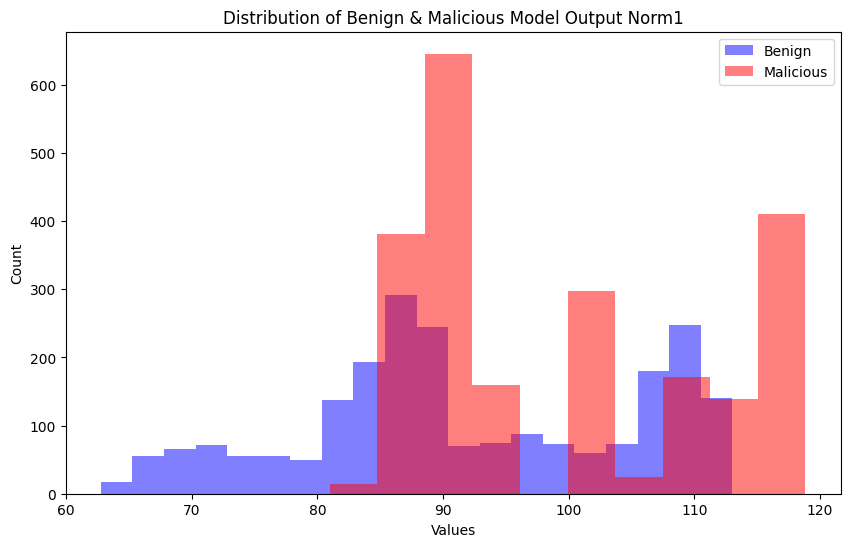

In [40]:
plot_dist_plt(
    benign_ts_model_out_norm1, 
    mal_ts_model_out_norm1_sampled, 
    'Distribution of Benign & Malicious Model Output Norm1',
    nbins_ben = 20, nbins_mal = 10,
    x_axis_range = [None, None]
)

### Plot original and reconstructed

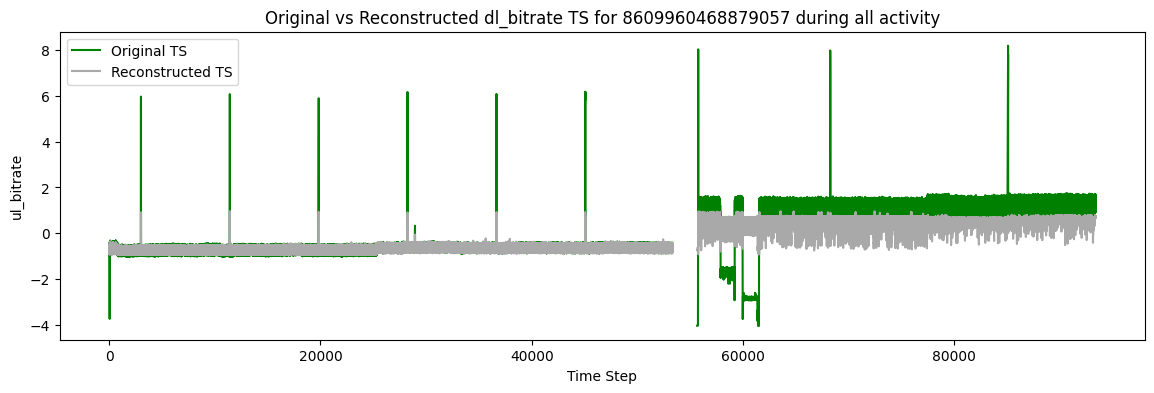

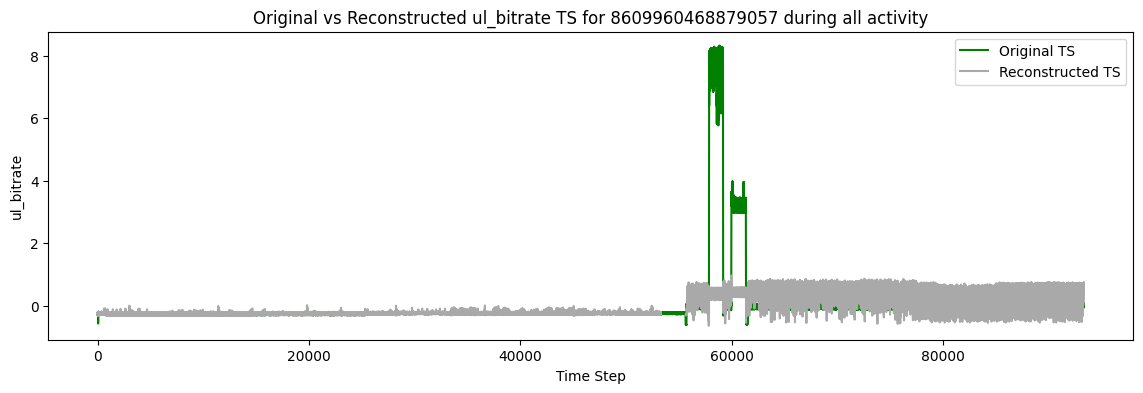

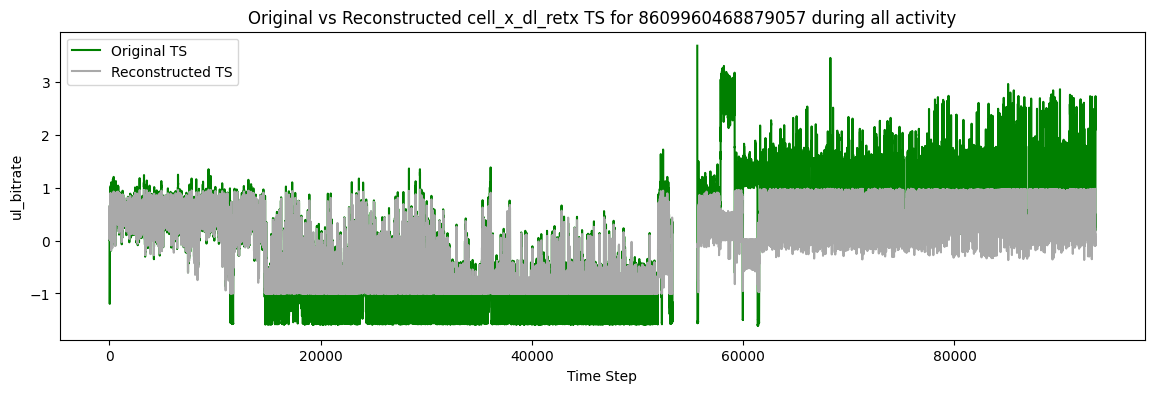

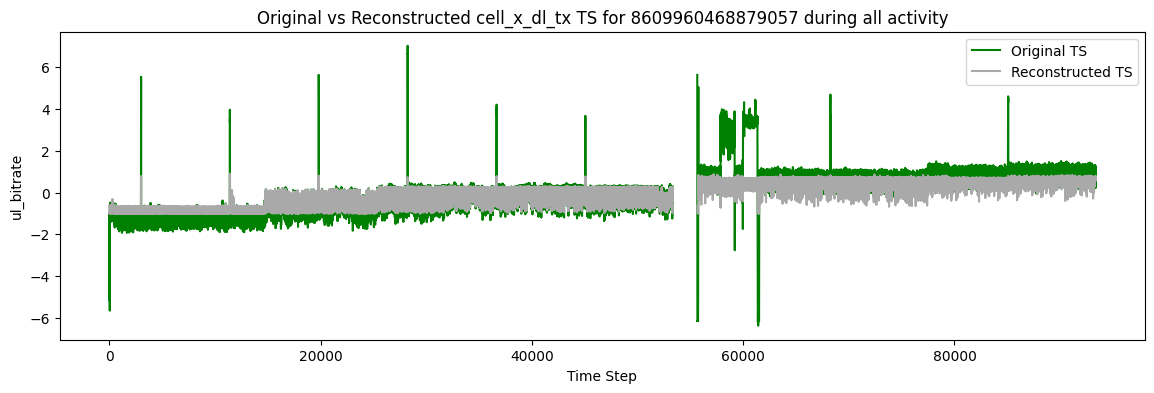

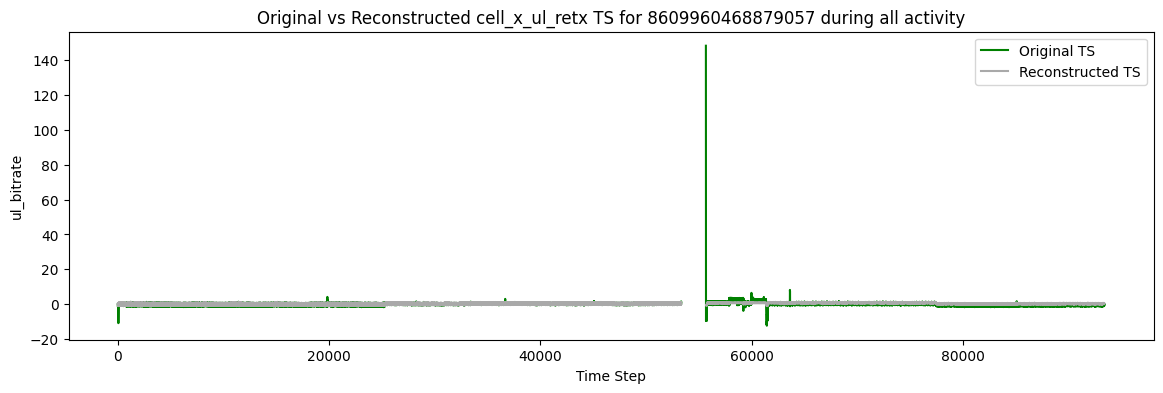

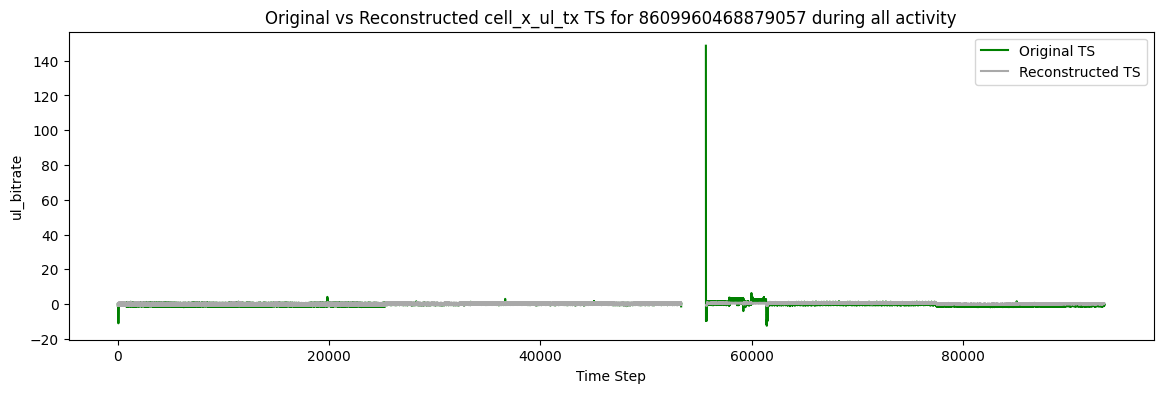

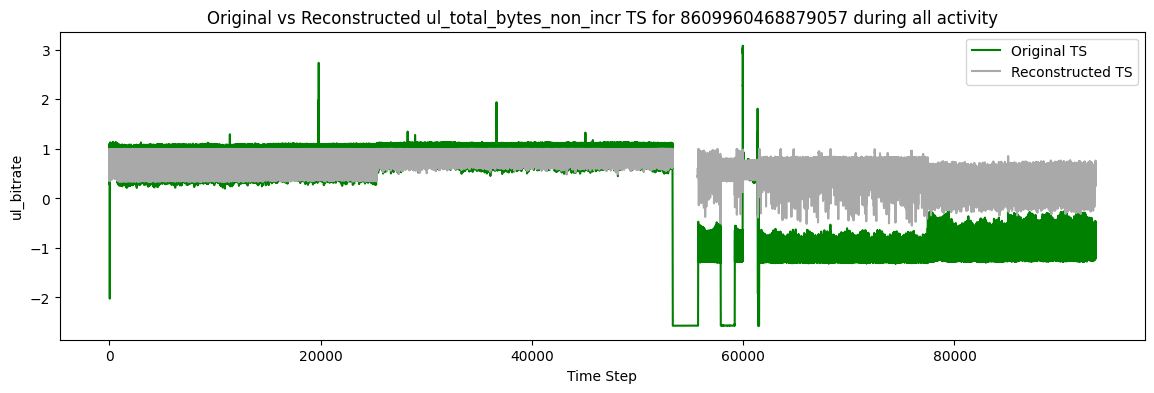

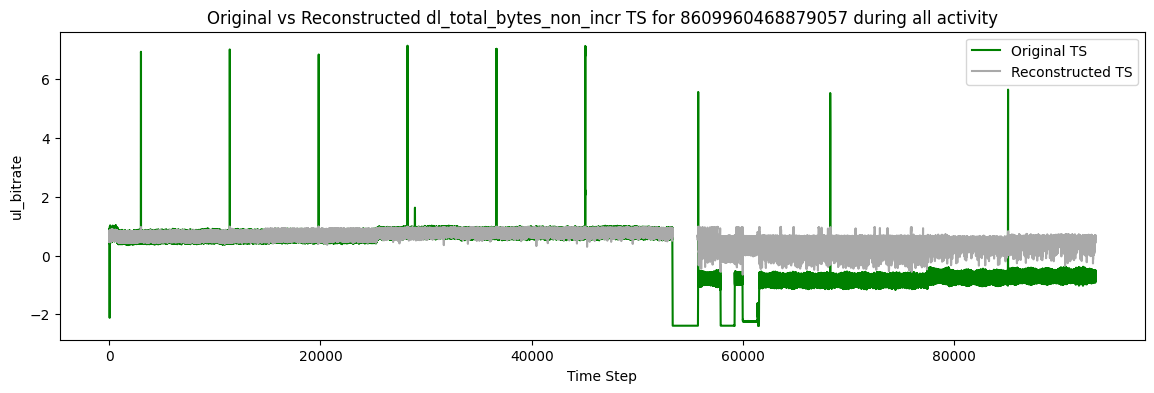

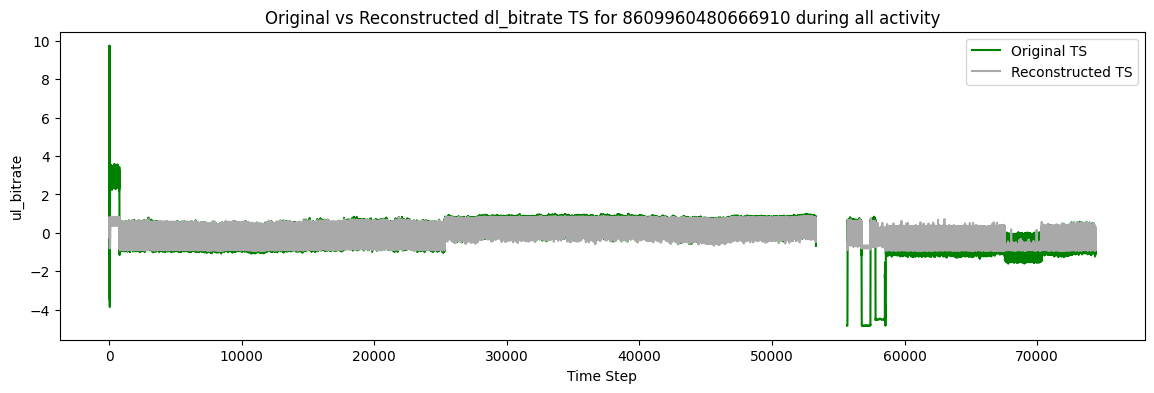

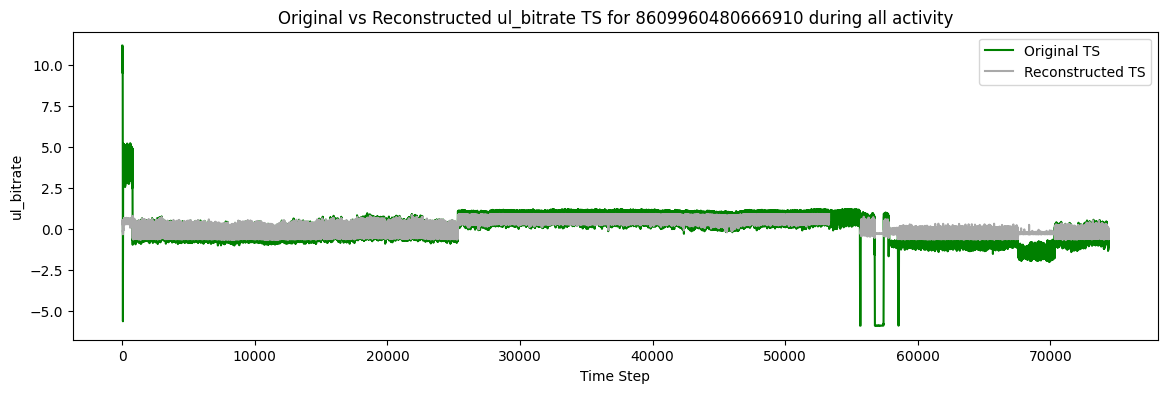

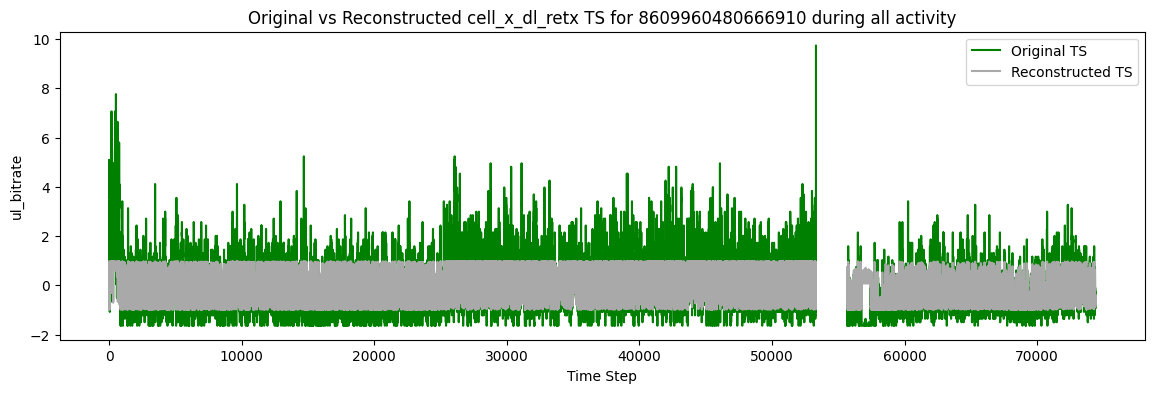

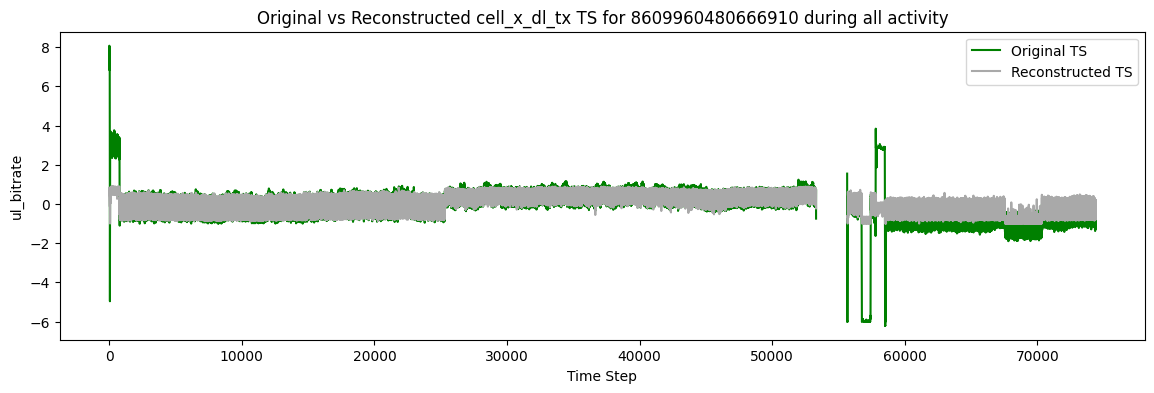

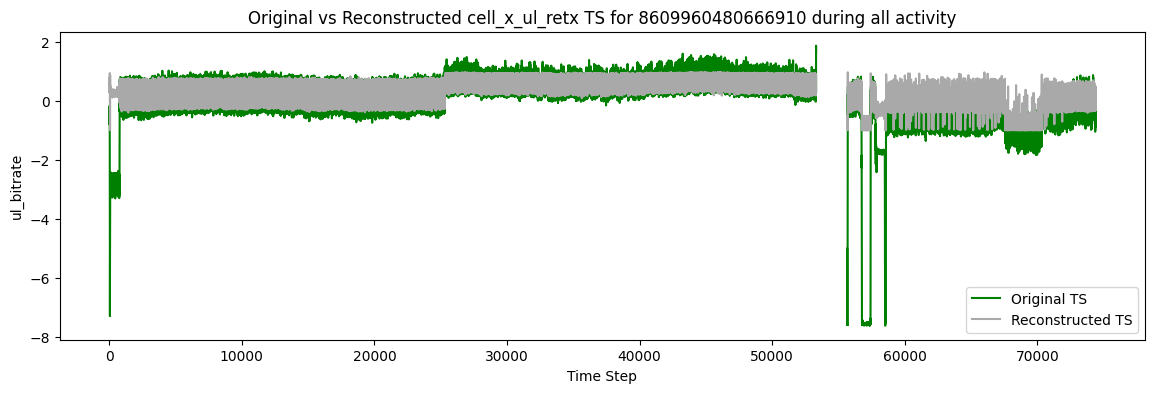

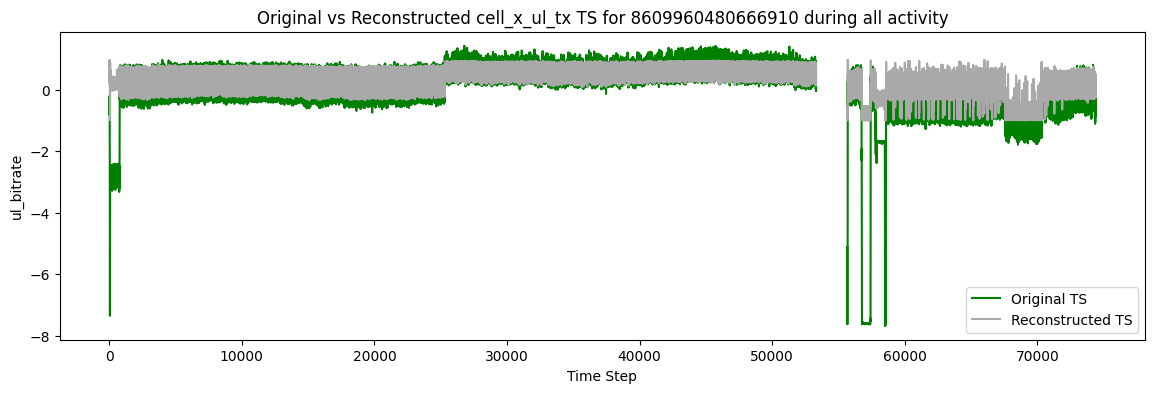

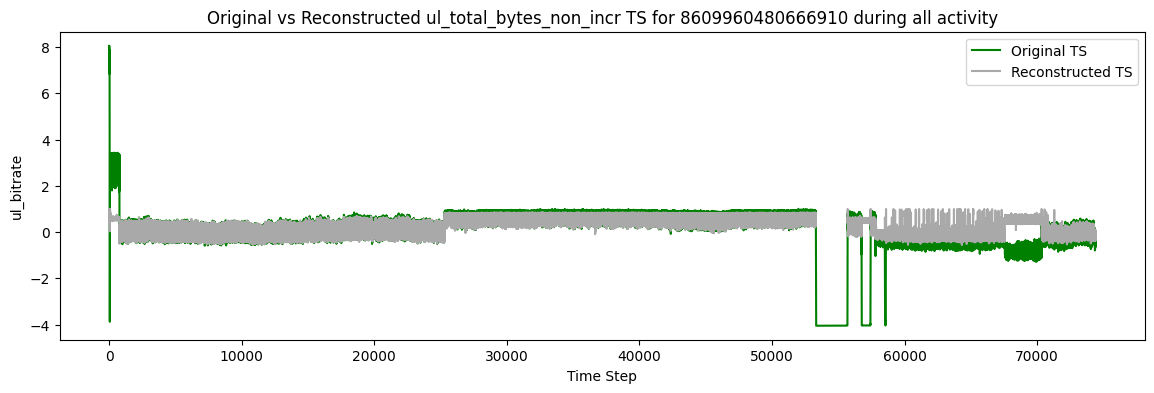

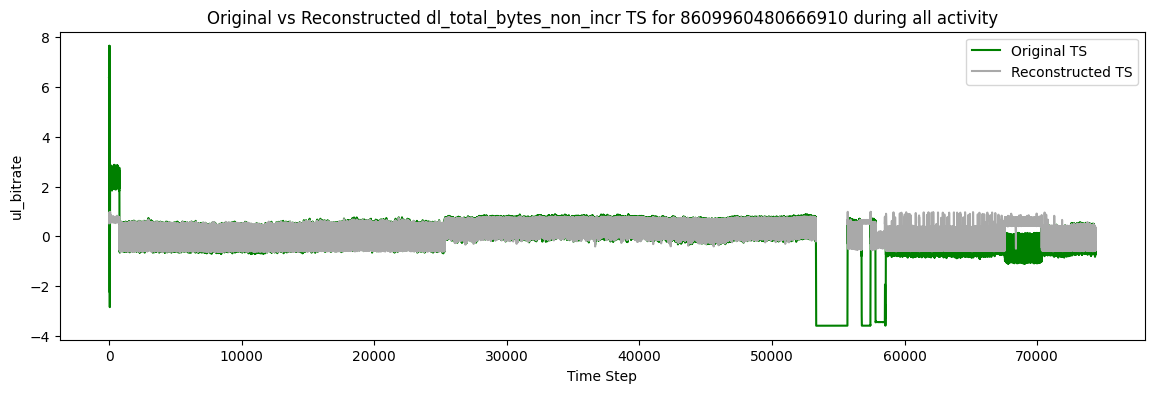

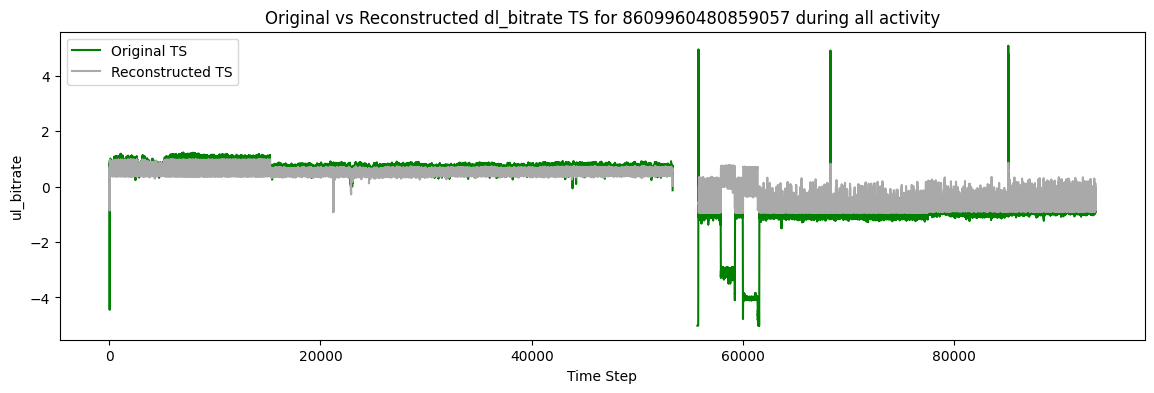

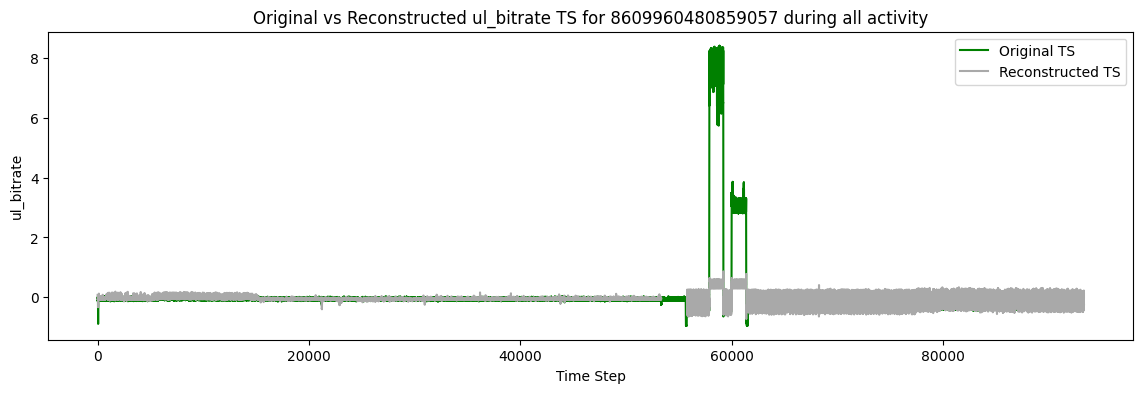

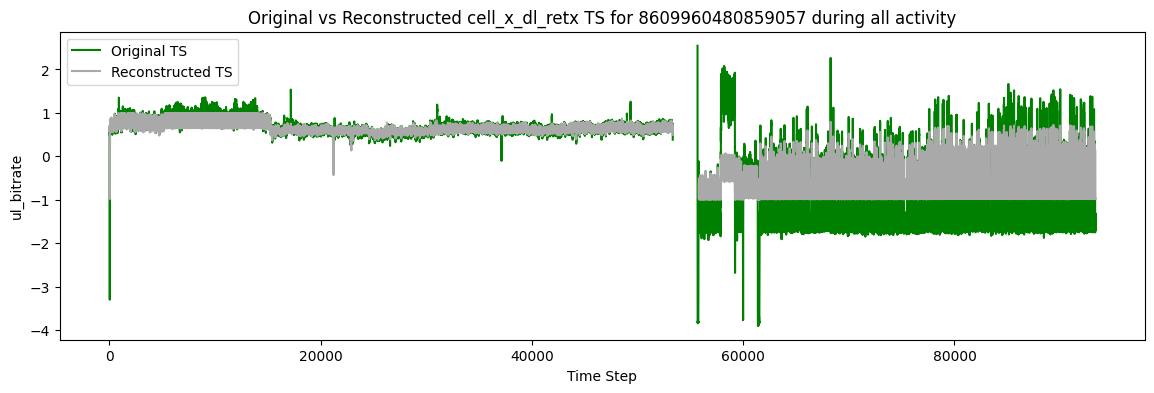

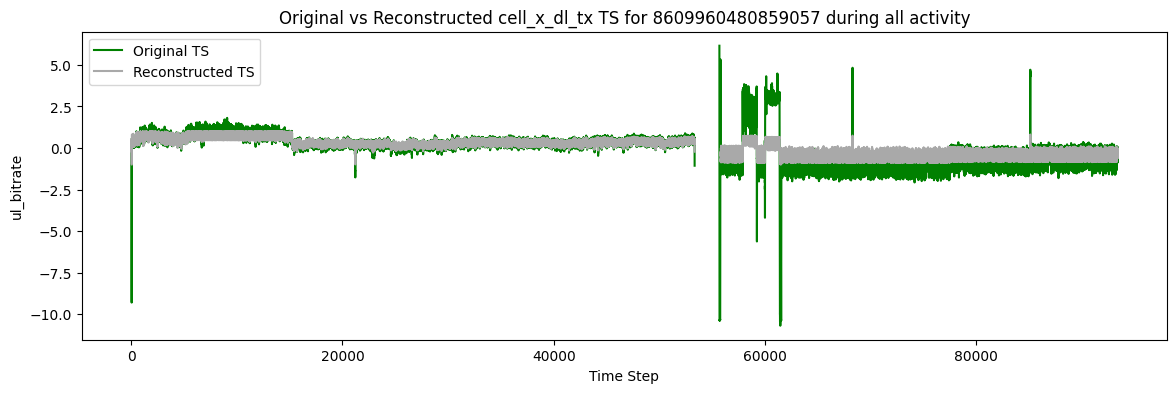

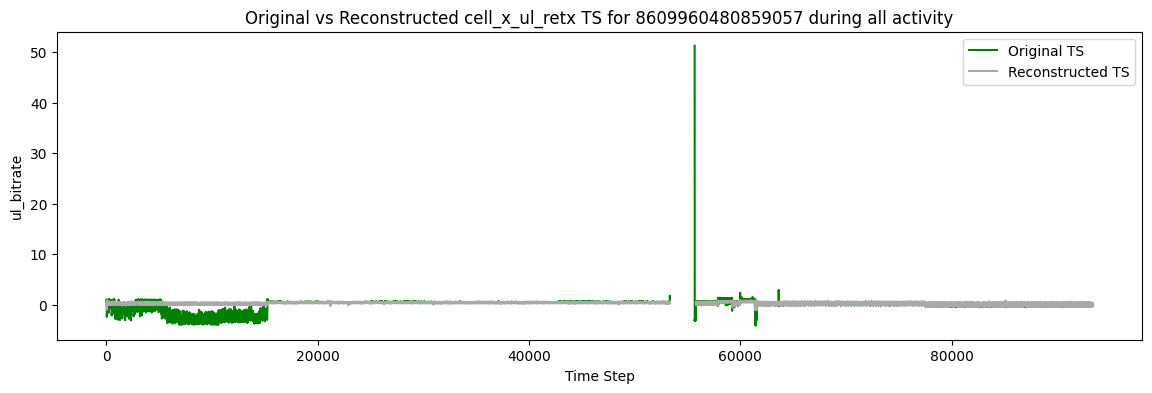

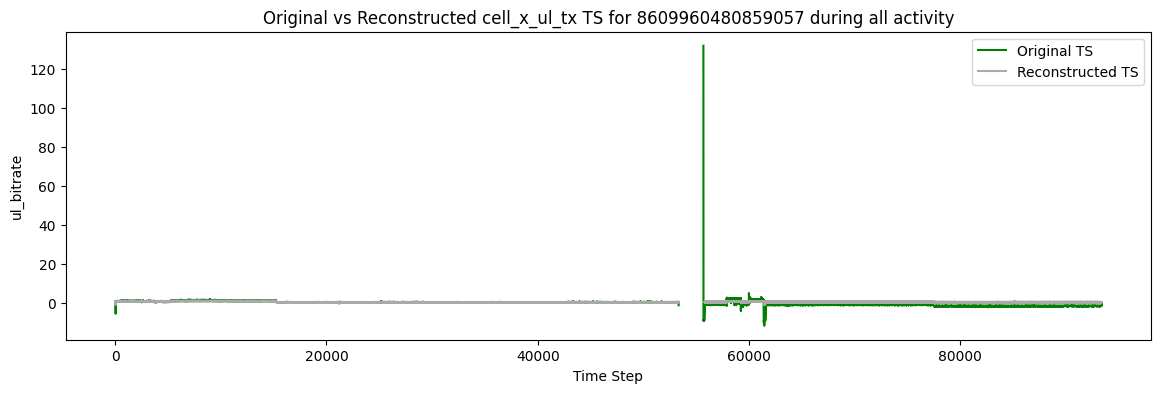

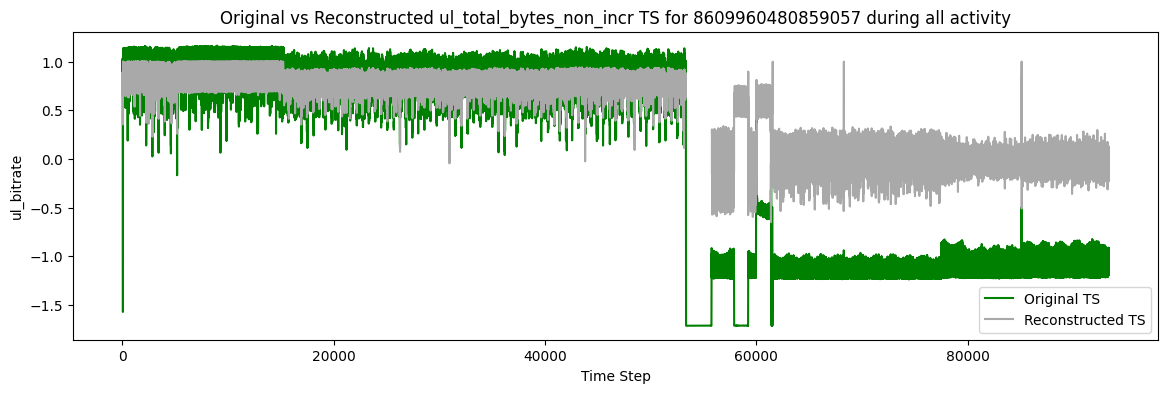

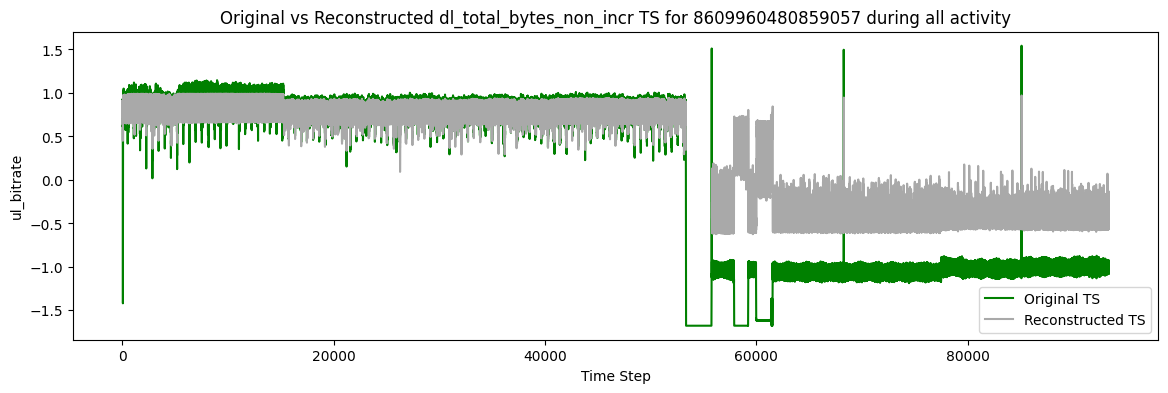

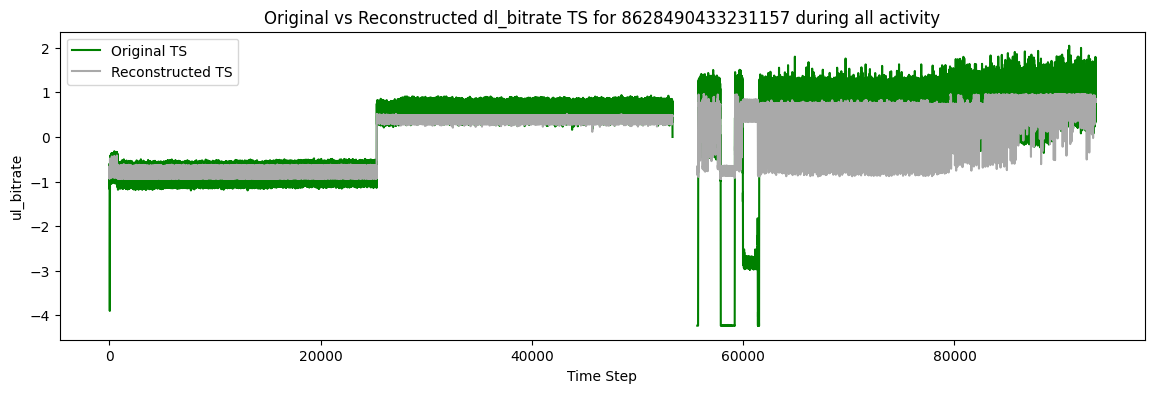

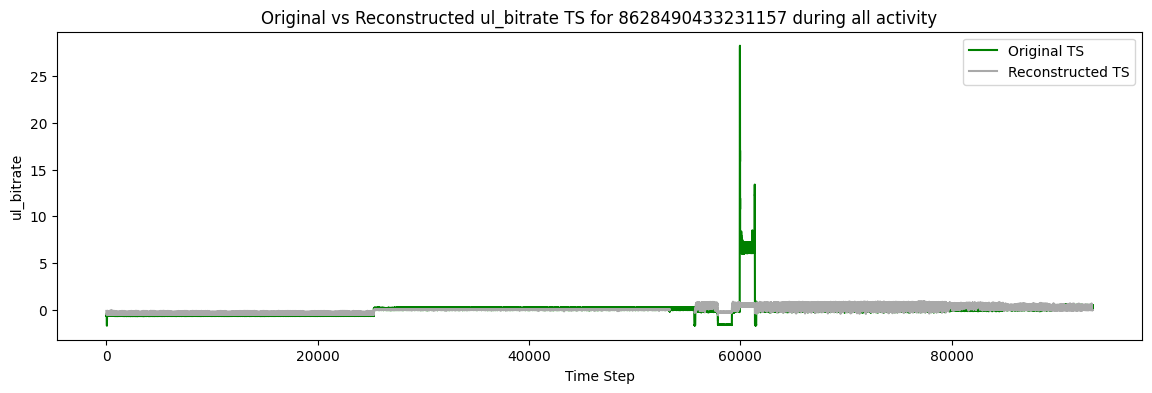

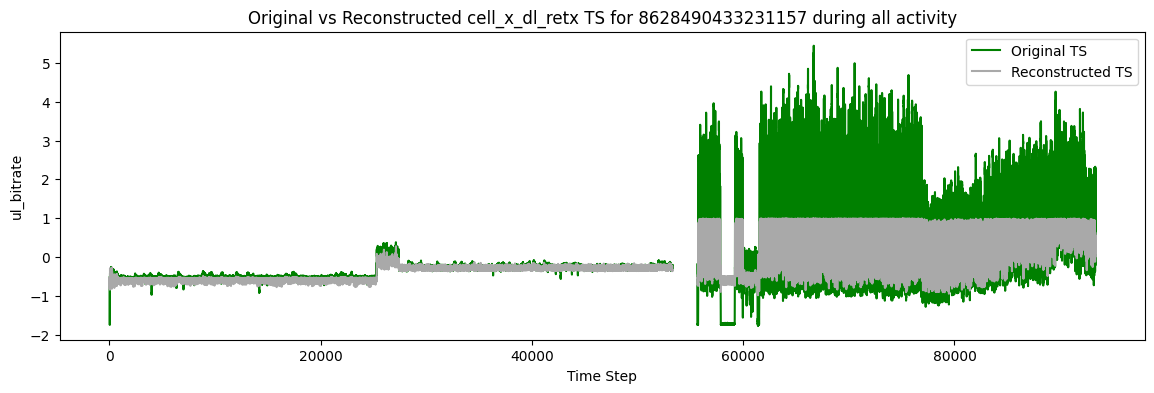

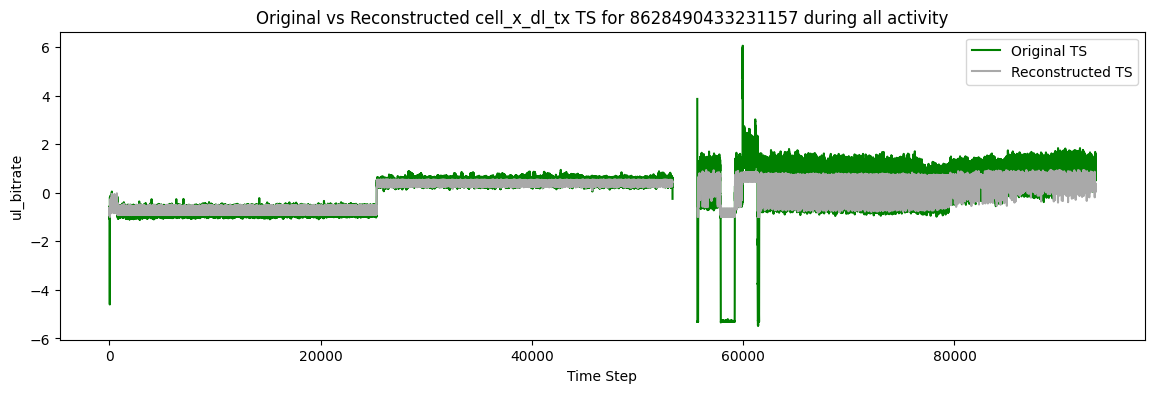

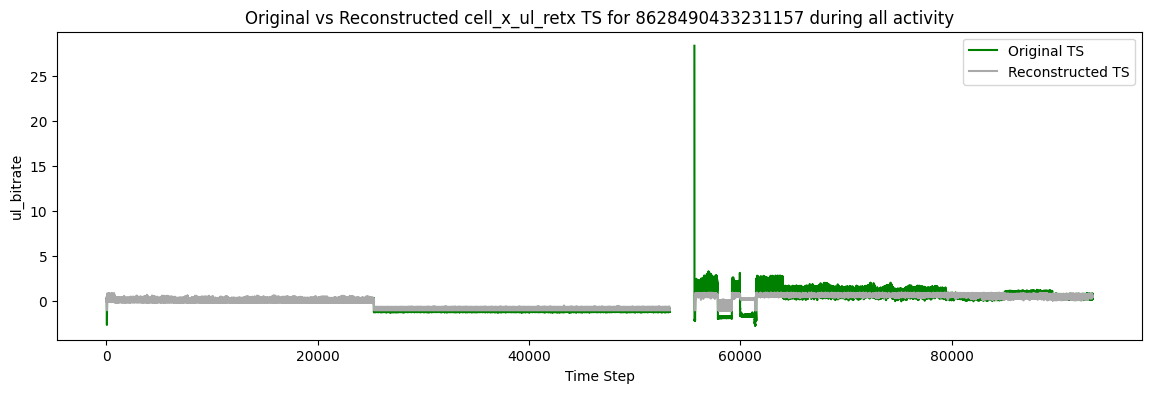

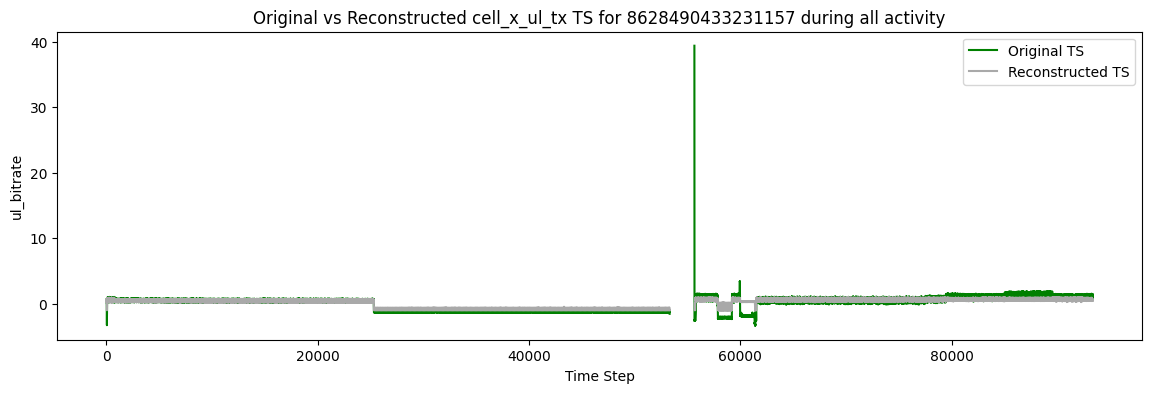

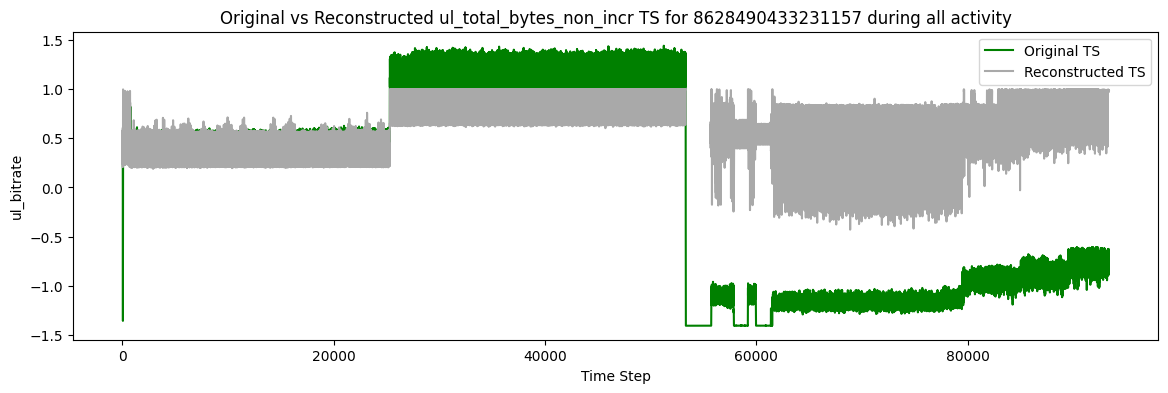

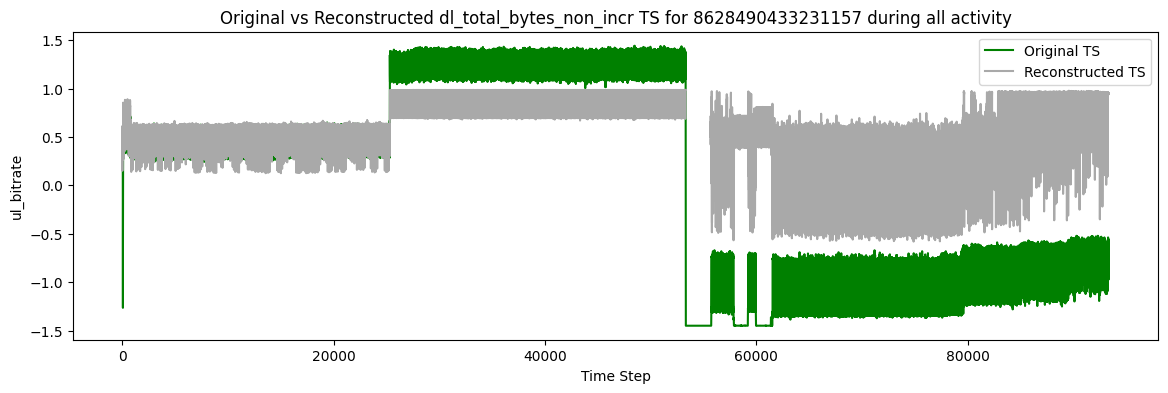

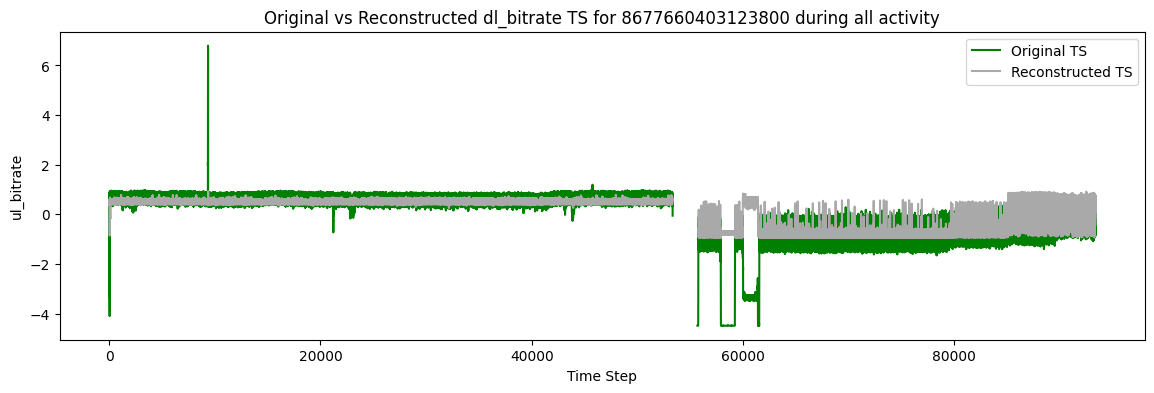

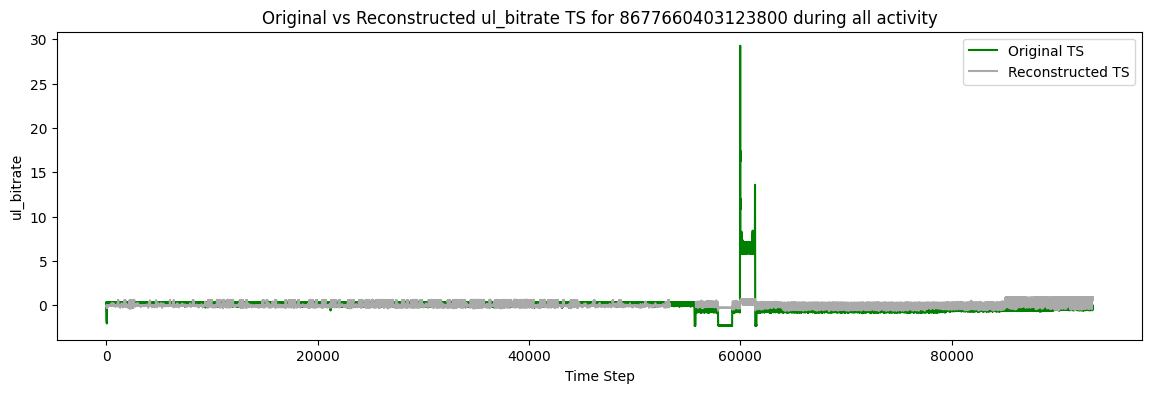

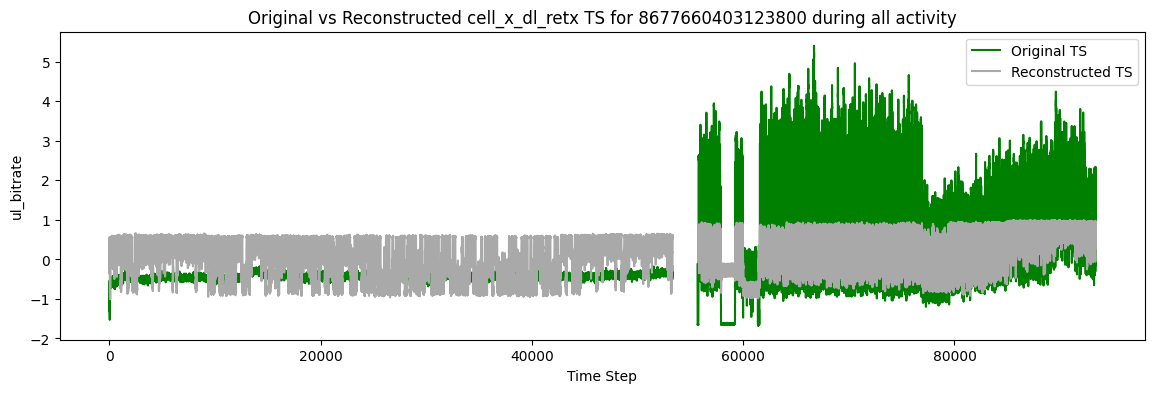

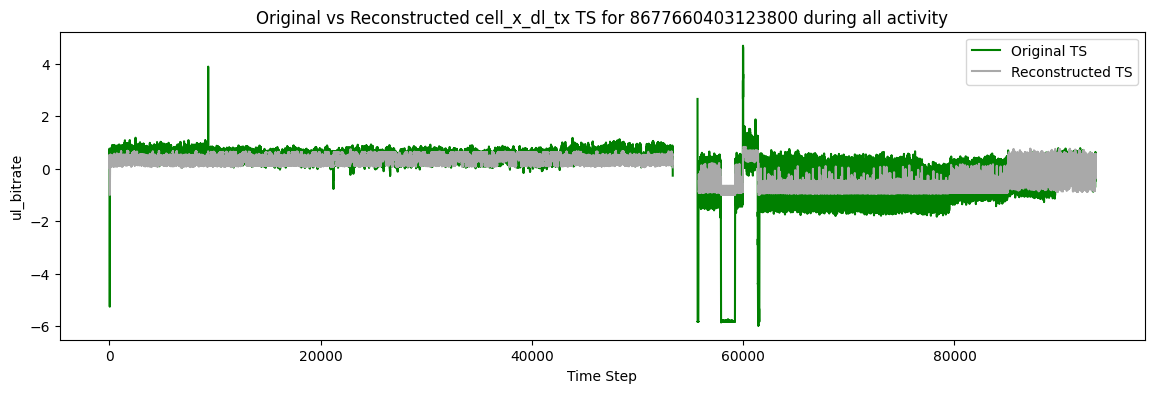

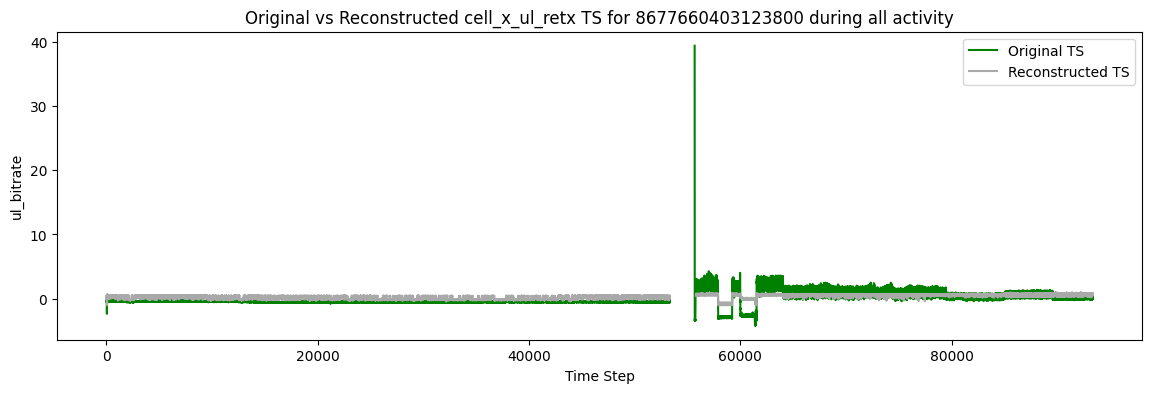

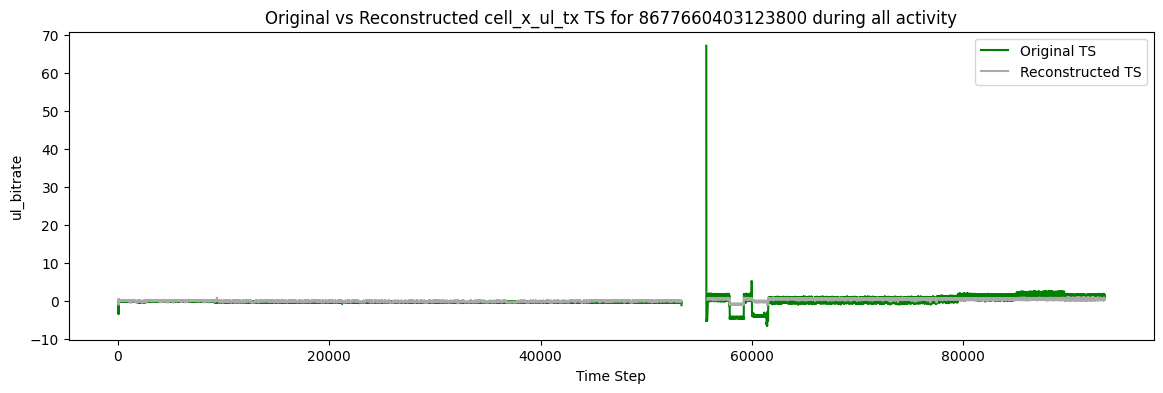

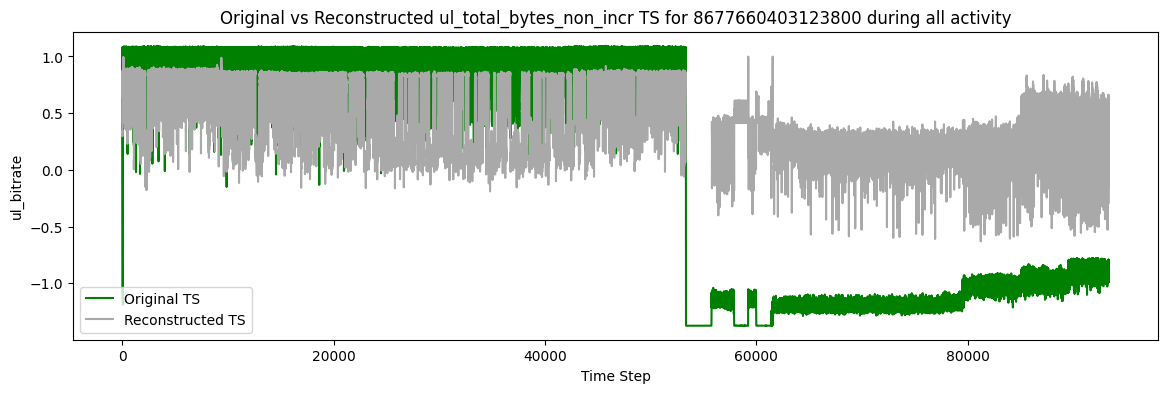

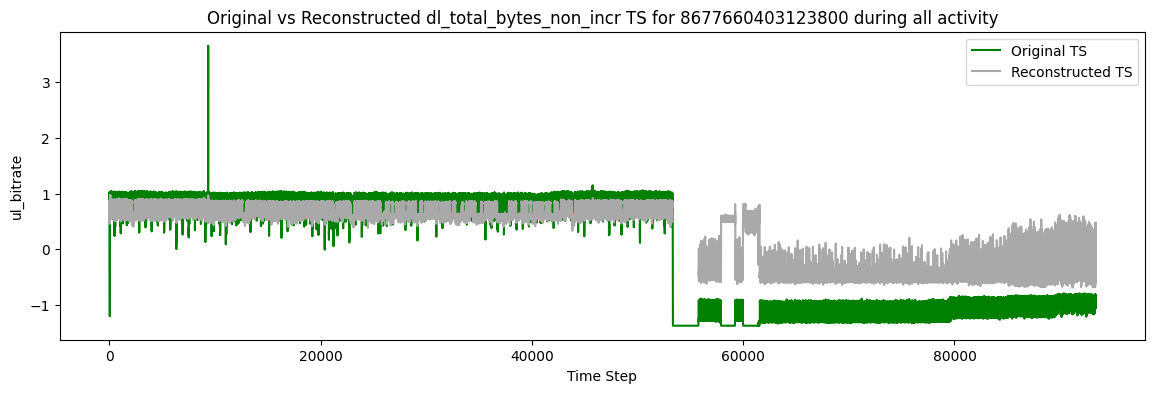

In [41]:
for imeisv in benign_data_train['imeisv'].unique():
    
    imeisv_series = df[
        (df['imeisv'] == imeisv)
    ].sort_values('_time', ascending = True)[feature_columns].iloc[30:]

    window_length = 120

    split_arrays = []

    for start in range(0, len(imeisv_series) - window_length + 1, window_length):
        end = start + window_length
        split_arrays.append(imeisv_series[start:end].values)
        
    model.to(device)
    model.eval()

    imeisv_original = []
    imeisv_rec = []
    with torch.no_grad(): 
        for ar in split_arrays:
            ar_tensor = torch.from_numpy(ar).to(device).float()
            imeisv_rec.append(model(ar_tensor).to('cpu').numpy())
            imeisv_original.append(ar_tensor.to('cpu').numpy())
    
    imeisv_original = functools.reduce(lambda a, b: np.concatenate([a,b]), imeisv_original)
    imeisv_rec = functools.reduce(lambda a, b: np.concatenate([a,b]), imeisv_rec)
    
    #imeisv_original = imeisv_original[:, np.newaxis]
    #imeisv_rec = imeisv_rec[:, np.newaxis]
    
    for num, feature in enumerate(feature_columns):

        fig, ax = plt.subplots(figsize=(14, 4))

        ax.plot(imeisv_original[:,num], label='Original TS', color='green')
        ax.plot(imeisv_rec[:,num], label='Reconstructed TS', color='darkgray')

        ax.legend()

        plt.title(f'Original vs Reconstructed {feature} TS for {imeisv} during all activity')
        plt.xlabel('Time Step')
        plt.ylabel('ul_bitrate')
        
        plt.show()